In [1]:
import sys
print(sys.executable)
!{sys.executable} -m pip install wordcloud


C:\ProgramData\anaconda3\python.exe
Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\josym\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\josym\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\josym\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\josym\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\josym\AppData\Roaming\nltk_data...
[

     label                                     processed_news
3600  true  pod decid expuls deput feder carl gaguim part ...
3601  true  bolsonar liberal complet diz presid psl part p...
3602  true  ministr stf lib andre nev prisa domicili decis...
3603  true  apes abundanc cresc preocupaca preservaca font...
3604  true  harvard mit levara dilm mor suplicy eua megaco...
...    ...                                                ...
3595  fake  julg popul usou dinh publ ajud afund brasil br...
3596  fake  not fiscal emit petrobr mostr gasolin vend bol...
3597  fake  esta estanc sangr bem debaix nariz lembr daque...
3598  fake  cidada fing possu pomb gir escap blitz lei sec...
3599  fake  autor cit expresso indic voc nao inteligenc em...

[7200 rows x 2 columns]
Acurácia do modelo: 94.67%
RU: 4688889
Palavras: 72, bigramas: 1367, Trigramas: 2161
   * Um total de 3601 tokens foram computadas a partir do conjunto de dados.



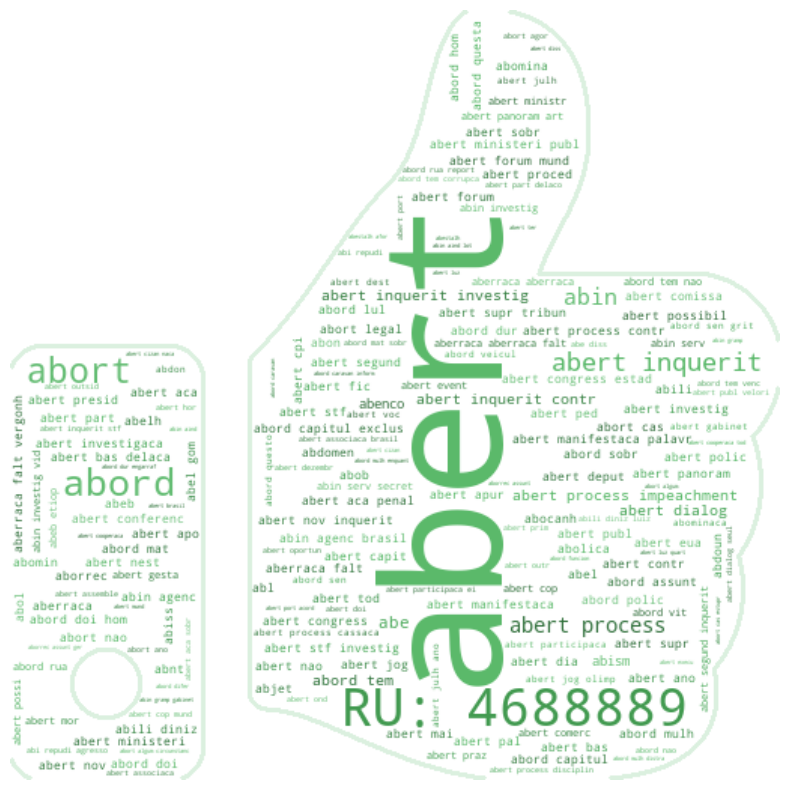

(<wordcloud.wordcloud.WordCloud at 0x21236cb23c0>, 3601)

In [15]:
# RU: 4688889

import pandas as pd
import nltk
from nltk import ngrams

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from funcoes_auxiliares import gerar_nuvem_palavras

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
import string

# Baixar recursos do NLTK
nltk.download("all")


# 1. Criação do dataframe a partir do CSV
df = pd.read_csv('pre-processed.csv')


# 2. Configuração stemmer e stopwords
stemmer = RSLPStemmer()
nltk.download('stopwords')

# Baixar o tokenizer
nltk.download('punkt')


# 3. Função de pré-processamento do texto
def preprocess_text(text):
    
    # Tokenização
    tokens = word_tokenize(text, language='portuguese')

    # Remover acentos e números, deixar minúsculas
    tokens = [t.lower() for t in tokens if t.isalpha()]

    # Remover stopwords e pontuações
    stop_words = set(stopwords.words('portuguese'))
    tokens = [t for t in tokens if t not in stop_words 
              and t not in string.punctuation]

     # Remover palavras muito curtas
    tokens = [t for t in tokens if len(t) > 2]

    # Aplicar o stemmer
    tokens = [stemmer.stem(t) for t in tokens]
    return ' '.join(tokens)


# 4. Pré-processamento no dataframe
df['preprocessed_news'] = df['preprocessed_news'].apply(preprocess_text)


# 5. Trunca os pares de notícias verdadeiras com falsas
#    para normalizar quantidade de palavras
df_truncated = pd.concat(
    [
        df[df['label'] == 'true'].head(len(df[df['label'] == 'fake'])),
        df[df['label'] == 'fake']
    ]
)


# 6. Remonta as notícias em string e cria coluna no dataframe 
# para o resultado do pré-processamento
df_truncated['processed_news'] = df_truncated['preprocessed_news']
print(df_truncated[['label', 'processed_news']])


# 7. Criação do modelo de classificação (Regressão Logística)
from sklearn.linear_model import LogisticRegression

# 7.1 Criar matriz de frequências TF-IDF com n-gramas de 1 a 3 palavras
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X = vectorizer.fit_transform(df_truncated['processed_news'])
y = df_truncated['label']

# 7.2 Divide o corpus pré-tratado em 75% para treinamento e 25% para testes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

# 7.3 Faz regressão logística com solver='lbfgs'
logreg_model = LogisticRegression(solver='lbfgs')
logreg_model.fit(X_train, y_train)

# 7.4 Realizar predição dos textos de teste com o método predict_proba
proba_predictions = logreg_model.predict_proba(X_test)

# 7.5 Calcular a acurácia geral do algoritmo
predicted_labels = logreg_model.predict(X_test)
accuracy = accuracy_score(y_test, predicted_labels)
print(f'Acurácia do modelo: {accuracy:.2%}')


# 8. Separar frequências para textos rotulados como verdadeiros
# Frequência total dos tokens no conjunto de treinamento
frequencias_treinamento = dict(
    zip(vectorizer.get_feature_names_out(), 
    X_train.sum(axis=0).A1))

# Índices dos textos verdadeiros
verdadeiras_indices = df_truncated[df_truncated['label'] == 'true'].index

# Features relevantes para textos verdadeiros
frequencias_verdadeiras = {
    token: frequencias_treinamento[token]
    for token in set(vectorizer.get_feature_names_out()
    [verdadeiras_indices]).intersection(frequencias_treinamento)}

# Converte para dicionário
frequencias_verdadeiras = dict(frequencias_verdadeiras)


# 9. Contagem de palavras, bigramas e trigramas
num_palavras = sum(1 for token in frequencias_verdadeiras.keys() 
    if ' ' not in token)
num_bigramas = sum(1 for token in frequencias_verdadeiras.keys()
    if ' ' in token and token.count(' ') == 1)
num_trigramas = sum(1 for token in frequencias_verdadeiras.keys()
    if ' ' in token and token.count(' ') == 2)

print(f'RU: 4688889')
print(f'Palavras: {num_palavras}, bigramas: {num_bigramas}, Trigramas: {num_trigramas}')

# Adiciona o RU ao dicionário com frequência 1
frequencias_verdadeiras[f'RU: 4688889'] = 10


# 10. Geração da nuvem de palavras usando a função auxiliar
gerar_nuvem_palavras(
    arquivo_mascara="thumbs_up_mask.png",
    dicionario_tokens_e_frequencia=frequencias_verdadeiras
)


RU: 4688889
Palavras: 36561, bigramas: 1176204, Trigramas: 2161216
   * Um total de 3373982 tokens foram computadas a partir do conjunto de dados.



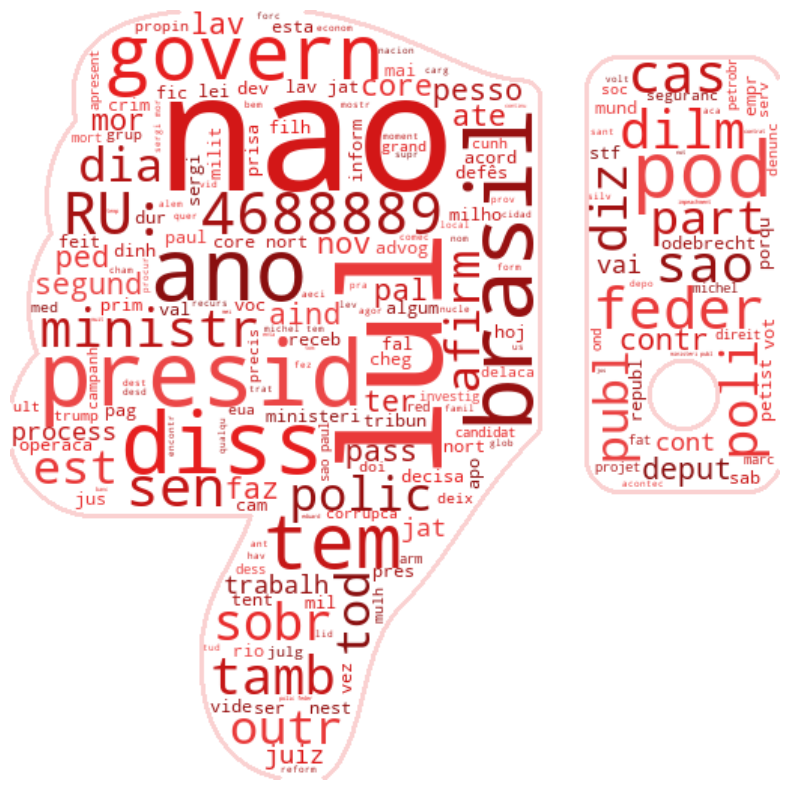

(<wordcloud.wordcloud.WordCloud at 0x21236a6e960>, 3373982)

In [19]:
# RU: 4688889

# 1. Frequências já calculadas no treino (mesmo dicionário)
frequencias_treinamento = dict(
    zip(vectorizer.get_feature_names_out(), X_train.sum(axis=0).A1)
)

# 2. Índices dos textos FALSOS no dataframe truncado
falsas_indices = df_truncated[df_truncated['label'] == 'fake'].index

# 3. Features relevantes para textos FALSOS
frequencias_falsas = {
    token: frequencias_treinamento[token]
    for token in set(vectorizer.get_feature_names_out()).intersection(
        frequencias_treinamento
    )
}

# 4. Contagem de palavras, bigramas e trigramas (dicionário – FALSAS)
num_palavras_false = sum(
    1 for token in frequencias_falsas.keys() if " " not in token
)

num_bigramas_false = sum(
    1 for token in frequencias_falsas.keys()
    if " " in token and token.count(" ") == 1
)

num_trigramas_false = sum(
    1 for token in frequencias_falsas.keys()
    if " " in token and token.count(" ") == 2
)

print(f"RU: 4688889")
print(
    f"Palavras: {num_palavras_false}, "
    f"bigramas: {num_bigramas_false}, "
    f"Trigramas: {num_trigramas_false}"
)

# 5. Coloca o RU no dicionário de frequências FALSAS
frequencias_falsas["RU: 4688889"] = 50

# 6. Gerar a nuvem de palavras para FAKE
gerar_nuvem_palavras(
    arquivo_mascara="thumbs_down_mask.png",
    dicionario_tokens_e_frequencia=frequencias_falsas
)
